In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sri210","key":"5ec2d07d7590bfd50107af75205387c6"}'}

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p /root/.kaggle
!mv kaggle.json /root/.kaggle/


In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c rsna-pneumonia-detection-challenge

100% 3.66G/3.66G [00:51<00:00, 106MB/s]
100% 3.66G/3.66G [00:51<00:00, 76.2MB/s]


In [ ]:
!mkdir -p "/content/gdrive/My Drive/RSNA"


In [ ]:
!unzip rsna-pneumonia-detection-challenge.zip -d "/content/gdrive/My Drive/RSNA"

Streaming output truncated to the last 5000 lines.
  inflating: /content/gdrive/My Drive/RSNA/stage_2_train_images/d5231546-354e-4071-9af1-6644beabfd86.dcm  
  inflating: /content/gdrive/My Drive/RSNA/stage_2_train_images/d5252a78-3ea1-48e9-9ffb-e7535be3ce80.dcm  
  inflating: /content/gdrive/My Drive/RSNA/stage_2_train_images/d525eafb-8908-45fd-a942-48d07c435487.dcm  
  inflating: /content/gdrive/My Drive/RSNA/stage_2_train_images/d5265640-17db-4880-866d-d2952e32941c.dcm  
  inflating: /content/gdrive/My Drive/RSNA/stage_2_train_images/d5277276-f8f8-40e9-b8e1-791cf5d96ac0.dcm  
  inflating: /content/gdrive/My Drive/RSNA/stage_2_train_images/d528d9e9-647a-4e2e-a16c-bd5e32a5bbf5.dcm  
  inflating: /content/gdrive/My Drive/RSNA/stage_2_train_images/d5293a3e-f050-4b98-8bbf-1f40e25bced5.dcm  
  inflating: /content/gdrive/My Drive/RSNA/stage_2_train_images/d52cbb5a-1d0a-457d-8c72-0f7aeec21ca7.dcm  
  inflating: /content/gdrive/My Drive/RSNA/stage_2_train_images/d52ce67b-be7c-4349-8dc4-38562

In [ ]:
!pip install pydicom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/1.8 MB ? eta -:--:--
     ━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.6/1.8 MB 16.7 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 29.8 MB/s eta 0:00:00


In [ ]:
import os
import pydicom as dicom
import cv2

# Create directory to store converted JPG images
! mkdir "/content/gdrive/My Drive/RSNA/stage_2_test_images_jpg"
jpg_path = "/content/gdrive/My Drive/RSNA/stage_2_test_images_jpg"

# Path to DICOM images (stage_2_test_images)
folder_path = '/content/gdrive/My Drive/RSNA/stage_2_test_images'

# List DICOM files in the directory
images_path = os.listdir(folder_path)

# Loop over DICOM files and convert to JPG
for n, image in enumerate(images_path):
    ds = dicom.dcmread(os.path.join(folder_path, image))
    pixel_array_numpy = ds.pixel_array
    image = image.replace('.dcm', '.jpg')
    cv2.imwrite(os.path.join(jpg_path, image), pixel_array_numpy)
    if n % 1000 == 0:
        print('{} image converted'.format(n))

# %%
"""
## Creating Mask images
"""

# %%
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import csv

# Define paths
mask_path = "/content/gdrive/My Drive/RSNA/masks/"
csv_path = "/content/gdrive/My Drive/RSNA/stage_2_train_labels.csv"

# Open CSV file containing labels
sheet = open(csv_path, newline='')

# Get list of image filenames (excluding file extensions)
images_path = os.listdir(jpg_path)
images_path = [os.path.splitext(x)[0] for x in images_path]
images_path = [x.strip() for x in images_path]

# Initialize counter
i = 1

# Iterate over image filenames
for image_name in images_path:
    # Open CSV file
    sheet = open(csv_path, newline='')
    reader = csv.reader(sheet)
    # Iterate over rows in CSV
    for row in reader:
        if row[0] == image_name:
            print(image_name)
            print(i)
            i += 1
            # Check if pneumonia is present (class 1)
            if row[5] == '1':
                # Extract bounding box coordinates
                pt1 = (int(row[1].split('.')[0]), int(row[2].split('.')[0]))
                pt2 = (int(row[1].split('.')[0]) + int(row[3].split('.')[0]), int(row[2].split('.')[0]) + int(row[4].split('.')[0]))

                # Load mask image or create empty mask
                if os.path.isfile(mask_path + image_name + '.jpg'):
                    img = cv2.imread(mask_path + image_name + '.jpg')
                else:
                    img = np.zeros((1024, 1024, 3), dtype="uint8")

                # Draw bounding box on mask
                cv2.rectangle(img, pt1, pt2, (255, 255, 255), -1)
                # Save mask image
                cv2.imwrite(mask_path + image_name + '.jpg', img)
                #cv2_imshow(img)
            else:
                # Create empty mask
                img = np.zeros((1024, 1024, 3), dtype="uint8")
                # Save empty mask image
                cv2.imwrite(mask_path + row[0] + '.jpg', img)
    # Close CSV file
    sheet.close()

# %%
import os
jpg_path = "/content/gdrive/My Drive/RSNA/stage_2_test_images_jpg"
images_path = os.listdir(jpg_path)
len(images_path)

# %%
images_path = "/content/gdrive/My Drive/RSNA/stage_2_test_images"
ids = next(os.walk(images_path))[2] # list of names all images in the given path
print("No. of images = ", len(ids))

# %%
"""
# Loading images and masks into arrays
"""

# %%
from tqdm import tqdm_notebook
from skimage.io import imread
from skimage.transform import resize
import numpy as np

# Initialize arrays to store images and masks
X = np.zeros((200, 256, 256, 1), dtype=np.float32)
y = np.zeros((200, 256, 256, 2), dtype=np.float32)

# Paths to images and masks
images_path = "/content/gdrive/My Drive/RSNA/stage_2_test_images_jpg/"
mask_path = "/content/gdrive/My Drive/RSNA/masks/"

# Iterate over a subset of images (first 200)
import os
from skimage.io import imread
from skimage.transform import resize
import numpy as np
from tqdm.notebook import tqdm

# Path to the directory containing JPEG images
jpg_path = "/content/gdrive/My Drive/RSNA/stage_2_test_images_jpg"

# List JPEG files in the directory
ids = next(os.walk(jpg_path))[2]

# Initialize arrays to store images
X = np.zeros((200, 256, 256, 1), dtype=np.float32)

# Iterate over a subset of images (first 200)
for n, id_ in tqdm(enumerate(ids[:200]), total=200):
    # Load JPEG image
    img = imread(os.path.join(jpg_path, id_), as_gray=True)
    x_img = resize(img, (256, 256, 1), mode="constant", preserve_range=True)

    # Normalize image
    x_img = x_img / 255.0

    # Store image in array
    X[n] = x_img

# Now X contains the loaded and preprocessed images



mkdir: cannot create directory ‘/content/gdrive/My Drive/RSNA/stage_2_test_images_jpg’: File exists
0 image converted
1000 image converted
2000 image converted
No. of images =  3000


  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
!pip install pydicom
import pydicom as dicom
import cv2
import os
from google.colab.patches import cv2_imshow
import csv
import keras

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, GlobalMaxPooling2D
from keras.layers import Lambda, RepeatVector, Reshape
from tensorflow.keras.layers import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.metrics import MeanIoU
from keras.utils import to_categorical
from keras.callbacks import CSVLogger
import datetime


In [ ]:
im_height = 256
im_width = 256

In [ ]:

# %%
# Set some parameters
im_height = 256
im_width = 256

# %%
# Data generator class for efficient data flow
class DataGenerator(keras.utils.Sequence):
    def __init__(self, folder_path, csv_path, ratio, batch_size=32, img_height=256, img_width=256, shuffle=True, val=False):
        self.batch_size = batch_size
        self.folder_path = folder_path
        self.csv_path = csv_path
        self.ratio = ratio
        if val == False:
            self.image_names = os.listdir(folder_path)[:int(ratio * 200)]  # Train on 200 images
        else:
            self.image_names = os.listdir(folder_path)[-50:]  # Test on 50 images
        self.img_height = img_height
        self.img_width = img_width
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.image_names) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        list_IDs_temp = [self.image_names[k] for k in indexes]
        X, y = self.__data_generation(list_IDs_temp)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_names))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        X = np.zeros((self.batch_size, self.img_height, self.img_width, 1), dtype=np.float32)
        y = np.zeros((self.batch_size, self.img_height, self.img_width, 2), dtype=np.float32)

        for n, image_name in enumerate(list_IDs_temp):
            ds = dicom.dcmread(os.path.join(self.folder_path, image_name))
            pixel_array_numpy = ds.pixel_array
            x_img = pixel_array_numpy
            x_img = resize(x_img, (self.img_height, self.img_width, 1), mode='constant', preserve_range=True)

            # Draw masks
            sheet = open(self.csv_path, newline='')
            reader = csv.reader(sheet)
            mask = np.zeros((1024, 1024, 1), dtype="uint8")

            image_name = os.path.splitext(image_name)[0].strip()

            for row in reader:
                if row[0] == image_name:
                    if row[5] == '1':
                        pt1 = (int(row[1].split('.')[0]), int(row[2].split('.')[0]))
                        pt2 = (int(row[1].split('.')[0]) + int(row[3].split('.')[0]),
                               int(row[2].split('.')[0]) + int(row[4].split('.')[0]))
                        cv2.rectangle(mask, pt1, pt2, 255, -1)
            sheet.close()
            mask = resize(mask, (self.img_height, self.img_width, 1), mode='constant', preserve_range=True)
            mask.astype(int)
            mask /= 255
            mask = tf.keras.utils.to_categorical(mask, num_classes=2, dtype='float32')

            X[n] = x_img
            y[n] = mask

        return X, y

# %%
# Generators
images_path = "/content/gdrive/My Drive/RSNA/stage_2_train_images"
csv_path = "/content/gdrive/My Drive/RSNA/stage_2_train_labels.csv"

training_generator = DataGenerator(images_path, csv_path, 0.8, batch_size=32, img_height=256, img_width=256, shuffle=True, val=False)
validation_generator = DataGenerator(images_path, csv_path, 0.8, batch_size=32, img_height=256, img_width=256, shuffle=True, val=True)


In [ ]:
# Generators
training_generator = DataGenerator(images_path, csv_path, 0.8, batch_size=32, img_height=256, img_width=256, shuffle=True, val=False)
validation_generator = DataGenerator(images_path, csv_path, 0.8, batch_size=32, img_height=256, img_width=256, shuffle=True, val=True)

In [ ]:
gen = DataGenerator(images_path,csv_path, 0.8, batch_size = 32, img_height = 256, img_width = 256, shuffle = True, val = False)
x, y = gen.__getitem__(0)

Text(0.5, 1.0, 'mask')

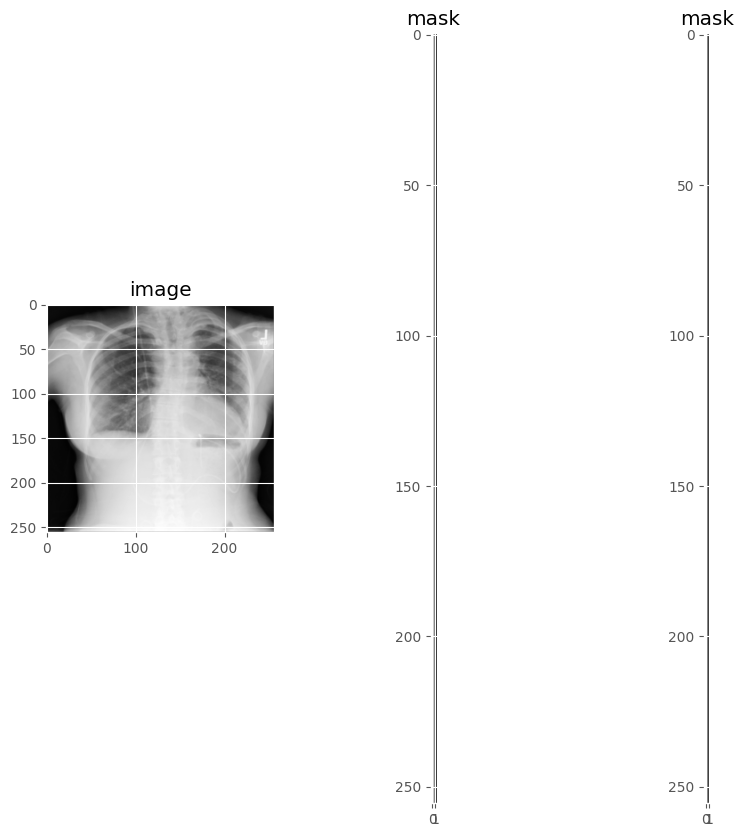

In [ ]:
# Visualize any random image along with the mask
ix = random.randint(0, len(x)-1)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 10))

ax1.imshow(x[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax1.set_title('image')

ax2.imshow(y[ix][0].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('mask')

ax3.imshow(y[ix][1].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax3.set_title('mask')

In [ ]:
from tensorflow.keras.losses import BinaryCrossentropy
def dice_coef(y_true, y_pred):

  smooth=1.0e-6
  #y_true_f_1 = tf.keras.backend.flatten(y_true[:,:,:,0])
  #y_pred_f_1 = tf.keras.backend.flatten(y_pred[:,:,:,0])
  y_true_f_2 = tf.keras.backend.flatten(y_true[:,:,:,1])
  y_pred_f_2 = tf.keras.backend.flatten(y_pred[:,:,:,1])
  #intersection_1 = tf.keras.backend.sum(y_true_f_1 * y_pred_f_1)
  intersection_2 = tf.keras.backend.sum(y_true_f_2 * y_pred_f_2)
  #union_1 = tf.keras.backend.sum(y_true_f_1) + tf.keras.backend.sum(y_pred_f_1)
  union_2 = tf.keras.backend.sum(y_true_f_2) + tf.keras.backend.sum(y_pred_f_2)

  score = 2*(intersection_2+smooth)/(union_2+smooth)
  return score

def DiceLoss(y_true, y_pred):

  score = dice_coef(y_true, y_pred)

  return 1 - score

In [ ]:
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (1,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
#keras.backend.clear_session()

In [ ]:
img_size = (im_height, im_width)
num_classes = 2
model = get_model(img_size, num_classes)
model.compile(optimizer=Adam(), loss = DiceLoss, metrics=[MeanIoU(num_classes=2), dice_coef])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 32)         320       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 128, 128, 32)         0         ['batch_normalization[0][0

In [ ]:
#callbacks = [ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=1),]
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience = 52, verbose=1, restore_best_weights=True)
checkpoint = ModelCheckpoint("/content/gdrive/My Drive/RSNA/best_model.h5", monitor='val_loss', verbose=1,
    save_best_only=True, mode='auto', save_freq = 'epoch')
csv_logger = CSVLogger("/content/gdrive/My Drive/RSNA/training.csv", separator=',', append=True)
logdir = "/content/gdrive/My Drive/RSNA/" + "logs/scalars/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)


callbacks = [earlystopping, checkpoint, csv_logger, tensorboard_callback]

In [ ]:
#results = model.fit(X_train, y_train, batch_size=32, epochs=50, callbacks=callbacks, validation_data=(X_valid, y_valid))

results = model.fit(training_generator,
                    validation_data=validation_generator,
                    epochs = 25,
                    callbacks=callbacks)

Epoch 1/25
5/5 [==============================] - ETA: 0s - loss: 0.9280 - mean_io_u: 0.2500 - dice_coef: 0.0720 
Epoch 1: val_loss improved from inf to 1.00000, saving model to /content/gdrive/My Drive/RSNA/best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5/5 [==============================] - 164s 30s/step - loss: 0.9280 - mean_io_u: 0.2500 - dice_coef: 0.0720 - val_loss: 1.0000 - val_mean_io_u: 0.2500 - val_dice_coef: 4.3731e-11
Epoch 2/25
5/5 [==============================] - ETA: 0s - loss: 0.8881 - mean_io_u: 0.2500 - dice_coef: 0.1119 
Epoch 2: val_loss did not improve from 1.00000
5/5 [==============================] - 142s 28s/step - loss: 0.8881 - mean_io_u: 0.2500 - dice_coef: 0.1119 - val_loss: 1.0000 - val_mean_io_u: 0.2500 - val_dice_coef: 3.1424e-11
Epoch 3/25
5/5 [==============================] - ETA: 0s - loss: 0.8139 - mean_io_u: 0.2500 - dice_coef: 0.1861 
Epoch 3: val_loss improved from 1.00000 to 0.98227, saving model to /content/gdrive/My Drive/RSNA/best_model.h5
5/5 [==============================] - 154s 31s/step - loss: 0.8139 - mean_io_u: 0.2500 - dice_coef: 0.1861 - val_loss: 0.9823 - val_mean_io_u: 0.2500 - val_dice_coef: 0.0177
Epoch 4/25
5/5 [==============================] - ETA: 0s - loss: 0.8115 - mean_

In [ ]:
model.save_weights('/content/gdrive/My Drive/RSNA/unet_model.h5')

#Saving the model to drive

#Plotting learning curve

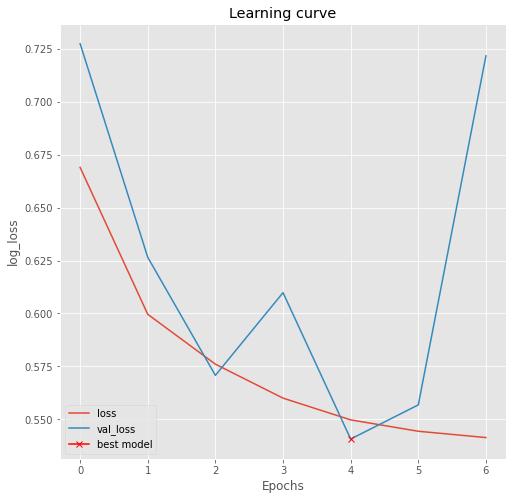

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

#Plotting Dice coefficient curve

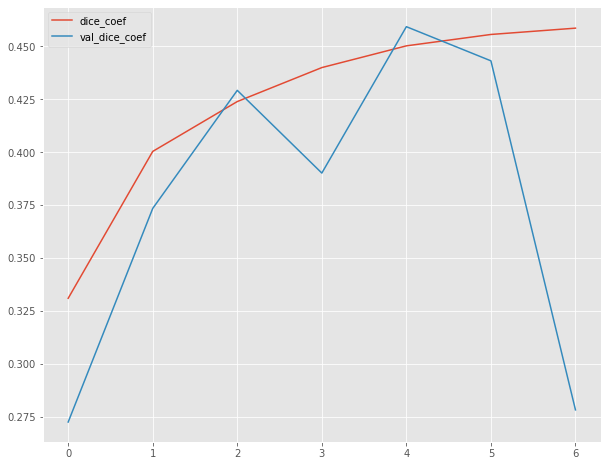

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(results.history['dice_coef'],label='dice_coef')
plt.plot(results.history['val_dice_coef'],label='val_dice_coef')
plt.legend()

#Evaluate on validation set

In [ ]:
model.evaluate(validation_generator, verbose=1)

166/166 [==============================] - 704s 4s/step - loss: 0.0242 - mean_io_u: 0.9528 - dice_coef: 0.9758


[0.02419264428317547, 0.9527525901794434, 0.9758071899414062]

Loading saved model

In [ ]:
from keras.models import load_model

model = load_model('/content/gdrive/My Drive/RSNA/best_model.h5', compile = False)

#Predictions on train and validation sets

In [ ]:
def plot_sample1():
    """Function to plot the results"""
    
    fig, ax = plt.subplots(1, 3, figsize=(20, 20))
    folder_path = '/content/gdrive/My Drive/RSNA/stage_2_train_images'
    csv_path = "/content/gdrive/My Drive/RSNA/stage_2_train_labels.csv" 
    #loading a random image

    ix = random.randint(0, len(ids))
    image_name = ids[ix]
    ds = dicom.dcmread(os.path.join(folder_path, image_name))
    pixel_array_numpy = ds.pixel_array
    x_img = pixel_array_numpy

    # Draw masks
    mask = np.zeros((1024, 1024, 1), dtype = "uint8")

    image_name = os.path.splitext(image_name)[0]
    image_name = image_name.strip()

    sheet = open(csv_path, newline='')
    reader = csv.reader(sheet)
    for row in reader:
        if row[0]==image_name:
          if row[5]=='1':
            pt1 = (int(row[1].split('.')[0]),int(row[2].split('.')[0]))
            pt2 = (int(row[1].split('.')[0])+int(row[3].split('.')[0]),int(row[2].split('.')[0])+int(row[4].split('.')[0]))
            cv2.rectangle(mask, pt1, pt2, (255), -1)     
    sheet.close()
    mask = resize(mask, (im_height, im_width, 1), mode = 'constant', preserve_range = True)

    #ground truth plot---------------------------------------------------------

    ax[0].imshow(x_img, cmap='gray', interpolation = 'bilinear')
    #ax[0].contour(mask.squeeze(), colors='black', levels=[0.5])
    ax[0].set_title('x_ray ground truth')

    #Mask ground truth plot---------------------------------------------------

    ax[1].imshow(mask.squeeze(), cmap='gray')
    ax[1].set_title('Mask ground truth')

    #Predicted mask plot --------------------------------------------------

    x_img = resize(x_img, (256, 256), mode = 'constant', preserve_range = True)
    img = np.expand_dims(x_img, axis=-1)
    x_test= np.zeros((1, 256, 256, 1), dtype=np.uint8)
    x_test[0]=img

    pred_test= model.predict(x_test, verbose=1)
    pred_test = np.argmax(pred_test, axis=-1)
    pred_test = pred_test[0]
    print(pred_test.shape)
    for i in range(pred_test.shape[0]):
            for j in range(pred_test.shape[1]):
                if pred_test[i][j] == 1:
                    pred_test[i][j] = 255
                else:
                    pred_test[i][j] = 0
    pred_test = cv2.merge((pred_test,pred_test, pred_test))
    '''
    contours, hierarchy = cv2.findContours(pred_test,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    for each_contour in contours:
        x,y,w,h = cv2.boundingRect(each_contour)
        cv2.rectangle(pred_test,(x,y),(x+w,y+h),(0,0,255),4)
        print (x,y,w,h)
    '''
    ax[2].imshow(pred_test, cmap='gray')
    
    ax[2].set_title('Predicted x_ray')

#Predictions on training set

In [ ]:
ids = os.listdir(images_path)
print(len(ids))

26684


1/1 [==============================] - 0s 23ms/step
(256, 256)
1/1 [==============================] - 0s 27ms/step
(256, 256)
1/1 [==============================] - 0s 24ms/step
(256, 256)
1/1 [==============================] - 0s 34ms/step
(256, 256)
1/1 [==============================] - 0s 25ms/step
(256, 256)
1/1 [==============================] - 0s 25ms/step
(256, 256)
1/1 [==============================] - 0s 26ms/step
(256, 256)
1/1 [==============================] - 0s 24ms/step
(256, 256)
1/1 [==============================] - 0s 26ms/step
(256, 256)
1/1 [==============================] - 0s 23ms/step
(256, 256)


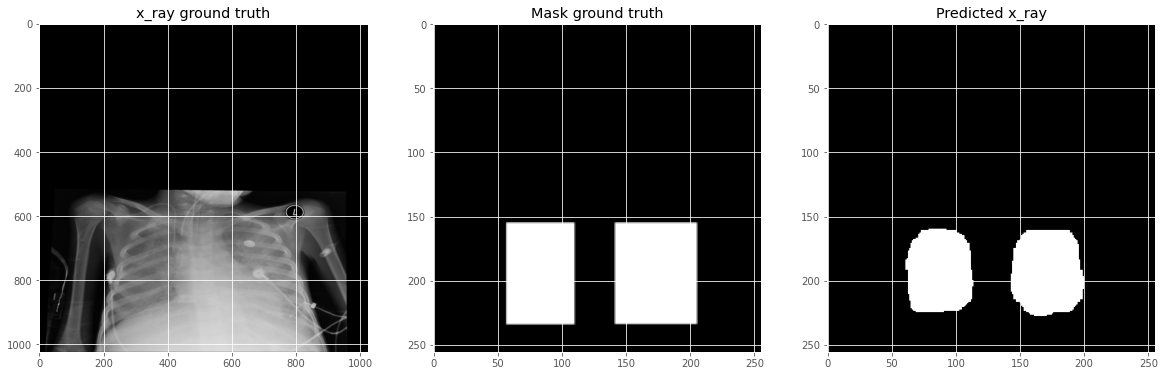

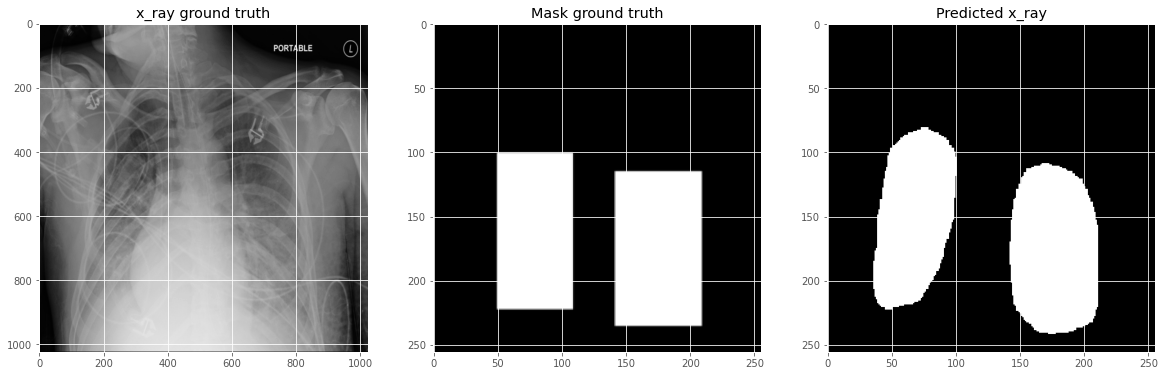

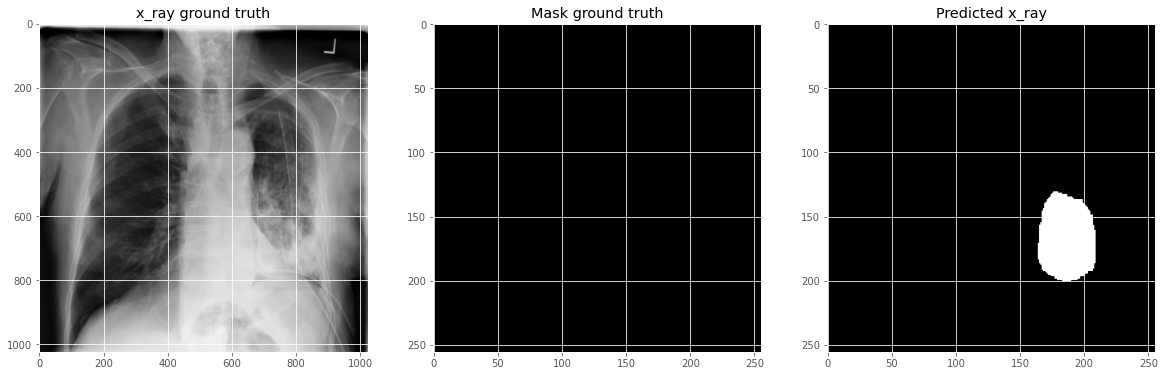

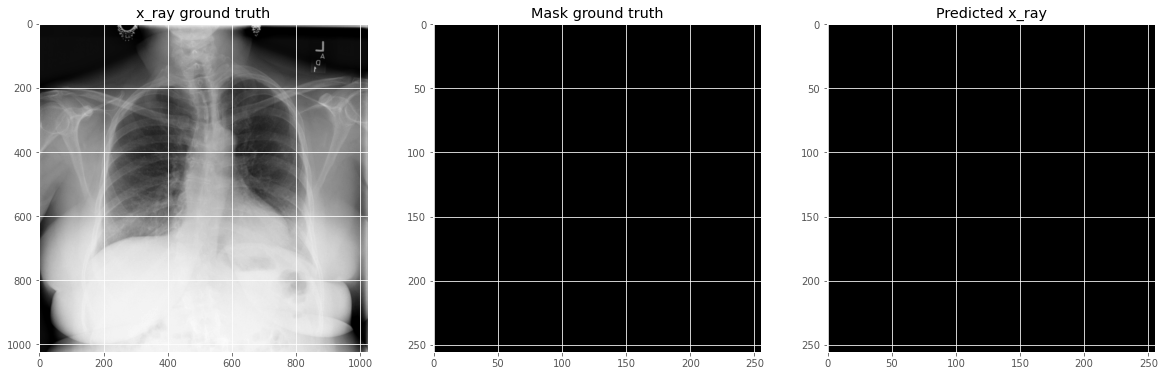

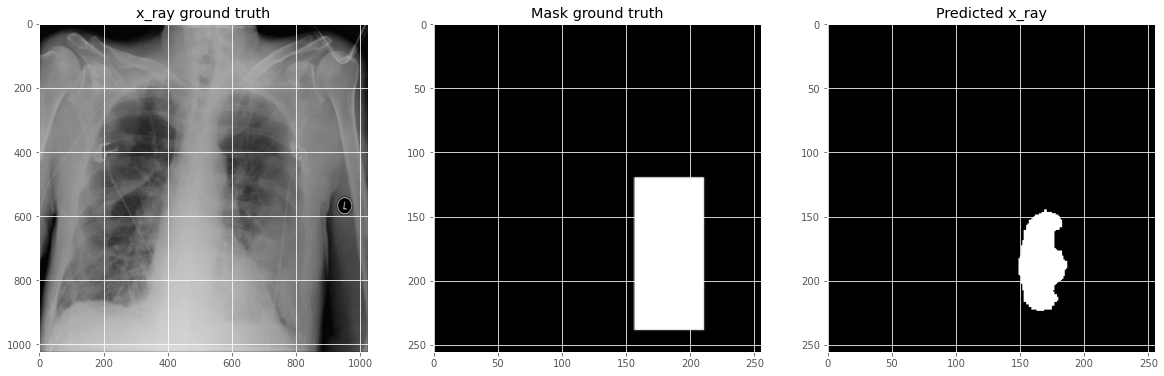

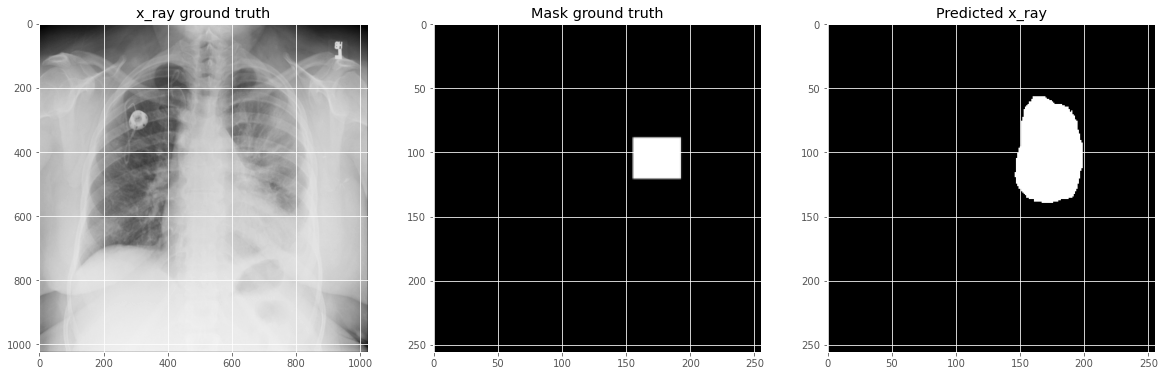

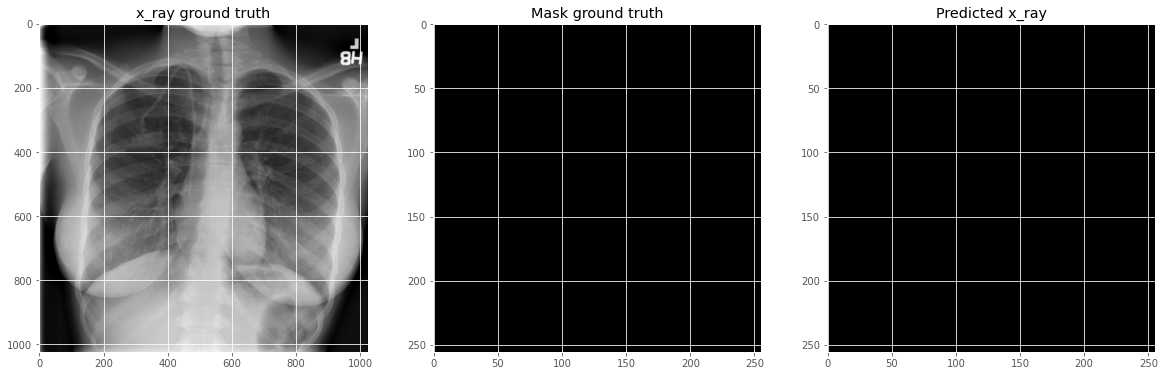

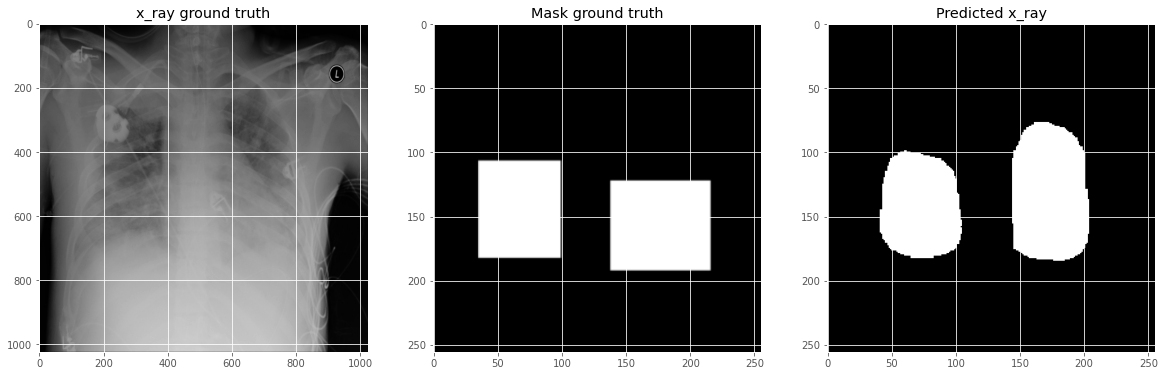

In [ ]:
for i in range(10):plot_sample1()

1/1 [==============================] - 0s 26ms/step
(256, 256)
1/1 [==============================] - 0s 24ms/step
(256, 256)
1/1 [==============================] - 0s 23ms/step
(256, 256)
1/1 [==============================] - 0s 25ms/step
(256, 256)
1/1 [==============================] - 0s 24ms/step
(256, 256)
1/1 [==============================] - 0s 33ms/step
(256, 256)
1/1 [==============================] - 0s 31ms/step
(256, 256)
1/1 [==============================] - 0s 30ms/step
(256, 256)
1/1 [==============================] - 0s 24ms/step
(256, 256)
1/1 [==============================] - 0s 24ms/step
(256, 256)


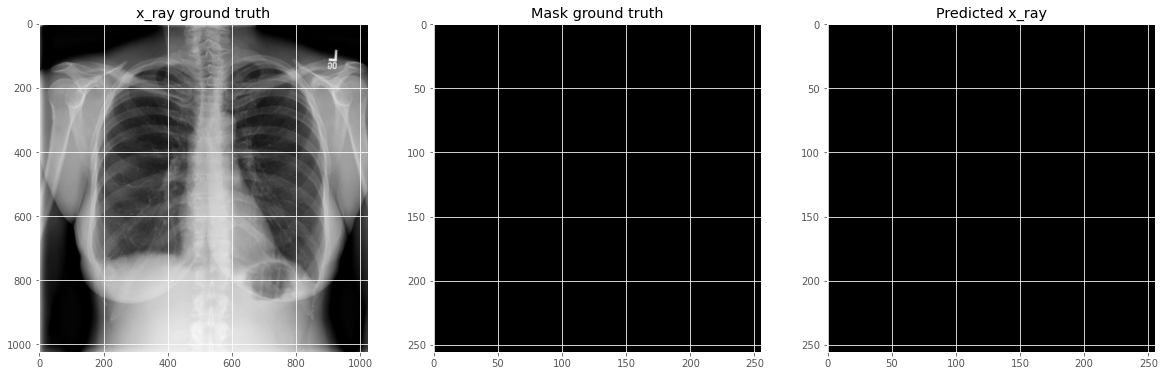

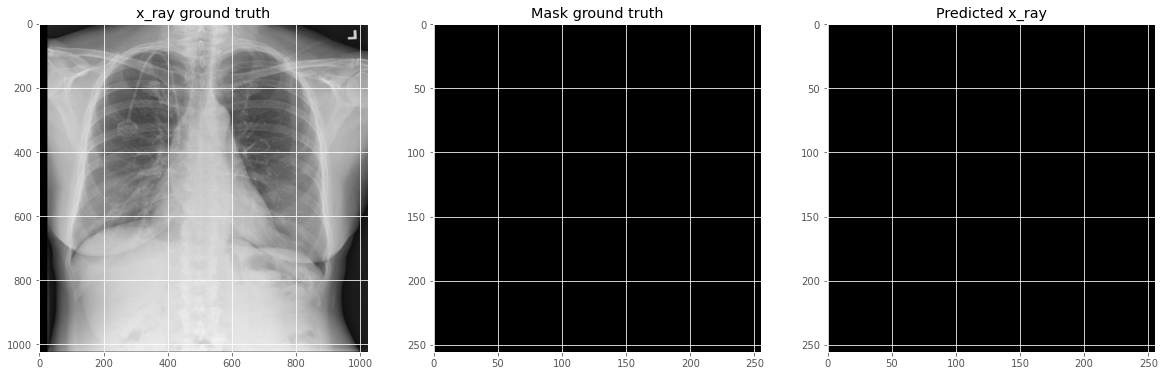

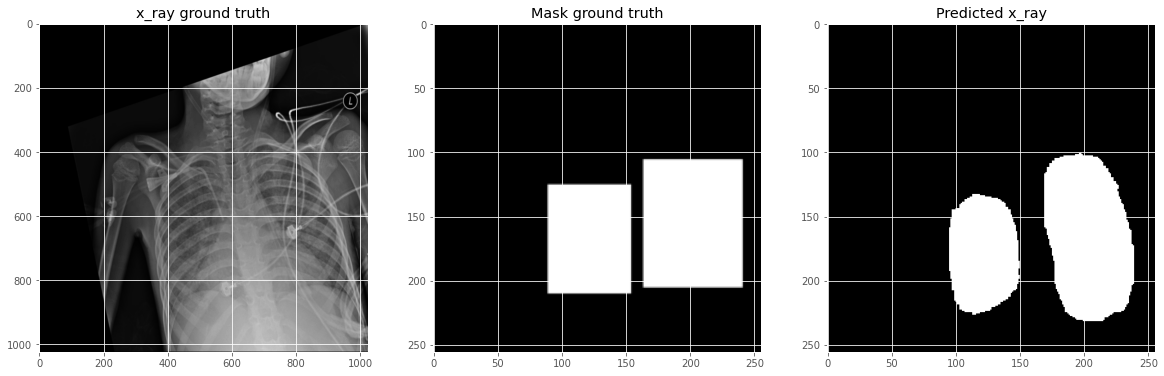

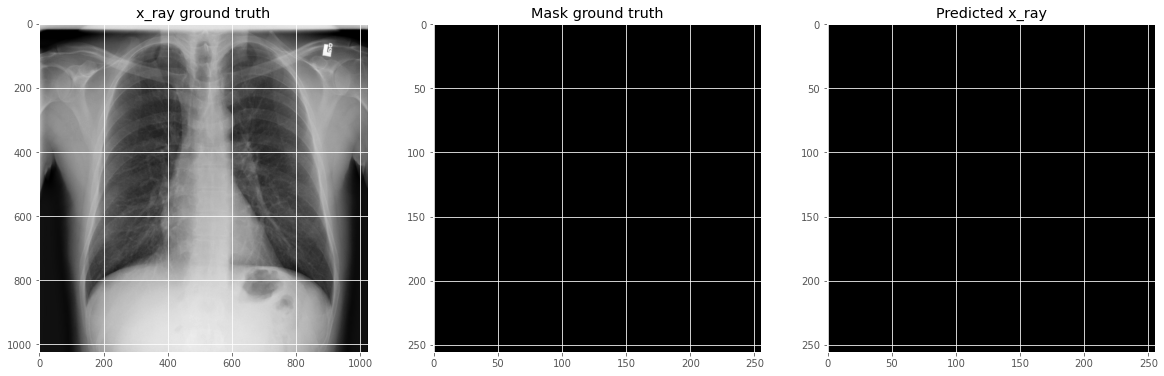

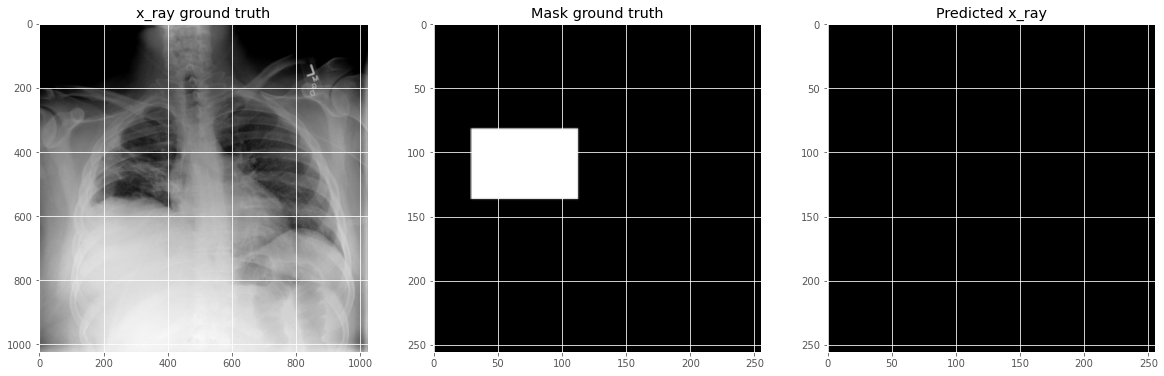

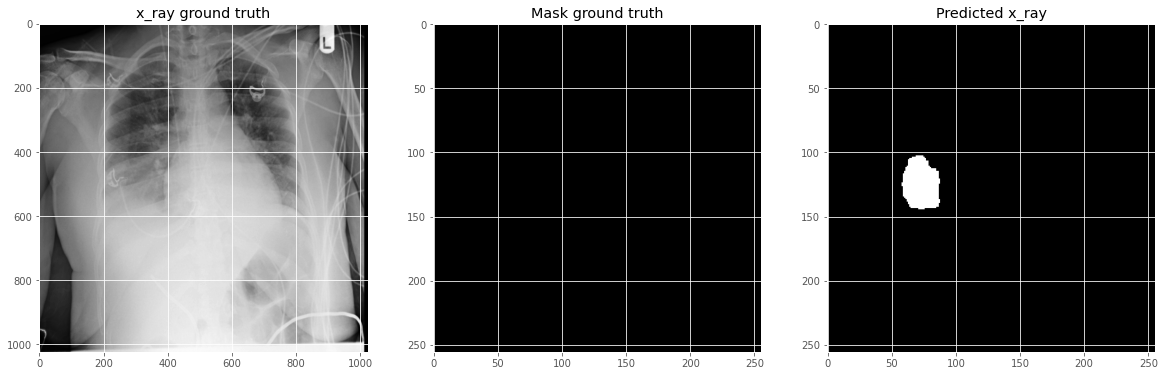

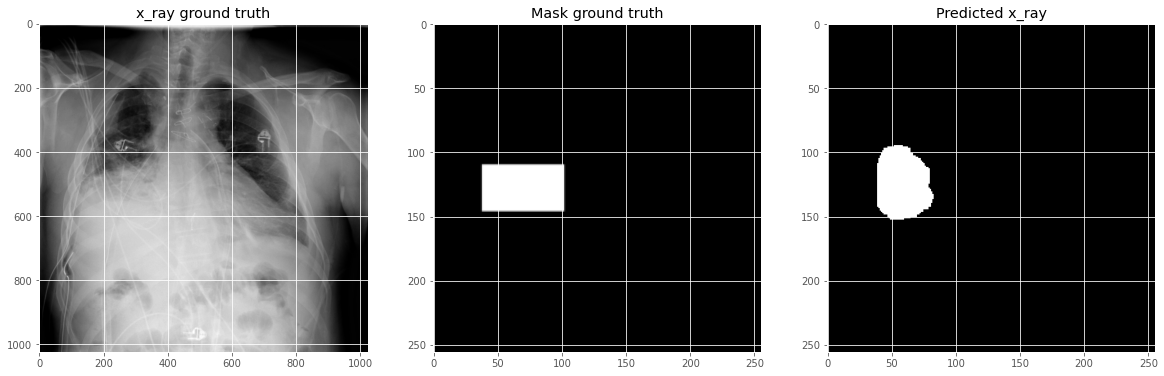

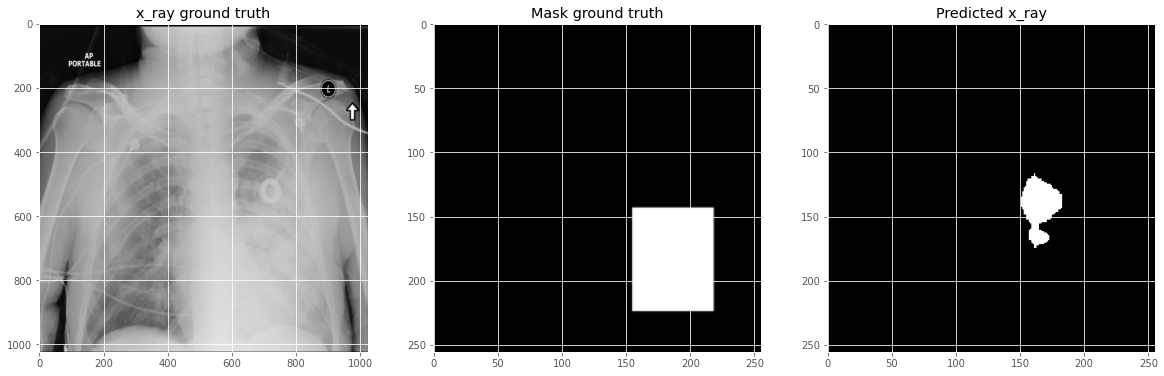

In [ ]:
for i in range(10):plot_sample1()

1/1 [==============================] - 0s 24ms/step
(256, 256)
1/1 [==============================] - 0s 26ms/step
(256, 256)
1/1 [==============================] - 0s 24ms/step
(256, 256)
1/1 [==============================] - 0s 25ms/step
(256, 256)
1/1 [==============================] - 0s 27ms/step
(256, 256)
1/1 [==============================] - 0s 23ms/step
(256, 256)
1/1 [==============================] - 0s 27ms/step
(256, 256)
1/1 [==============================] - 0s 22ms/step
(256, 256)
1/1 [==============================] - 0s 23ms/step
(256, 256)
1/1 [==============================] - 0s 18ms/step
(256, 256)


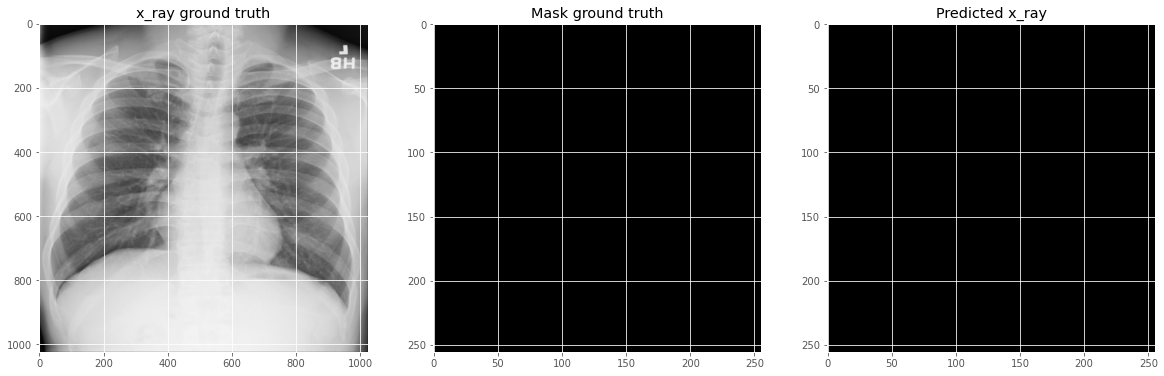

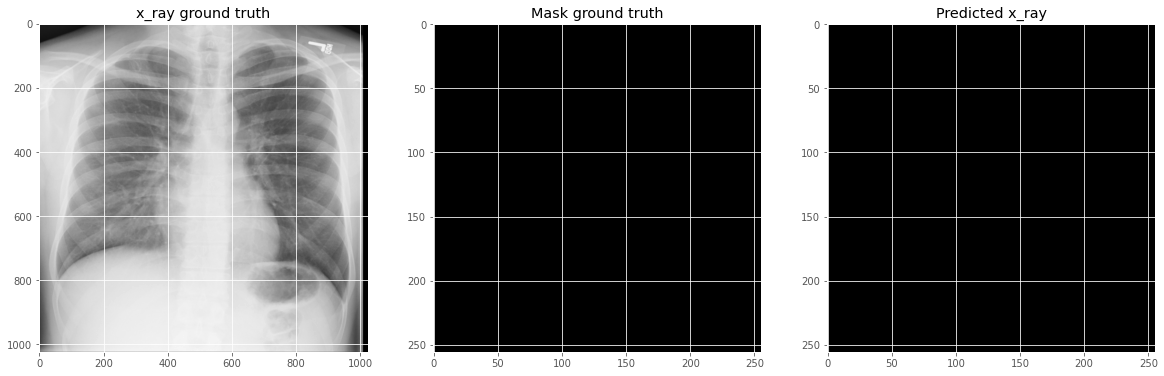

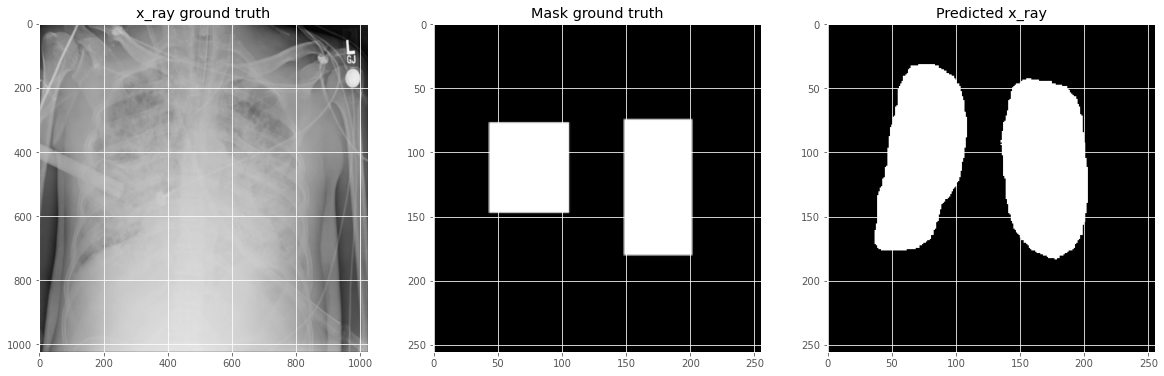

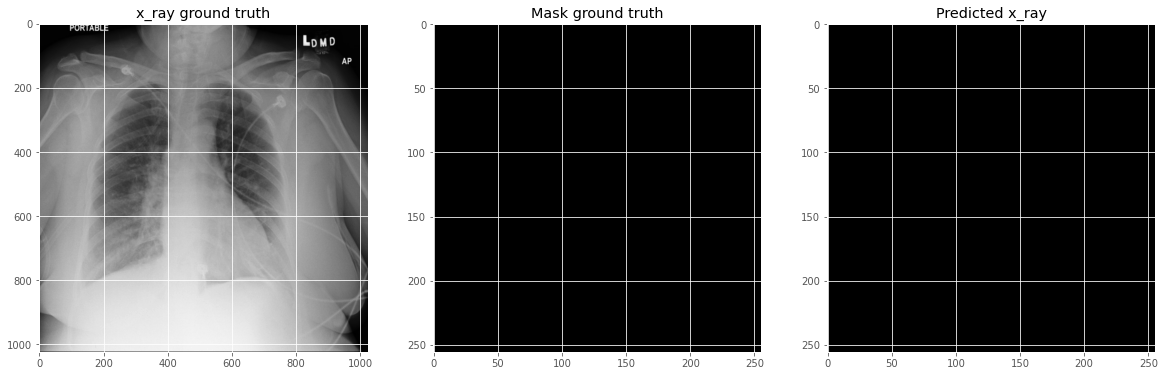

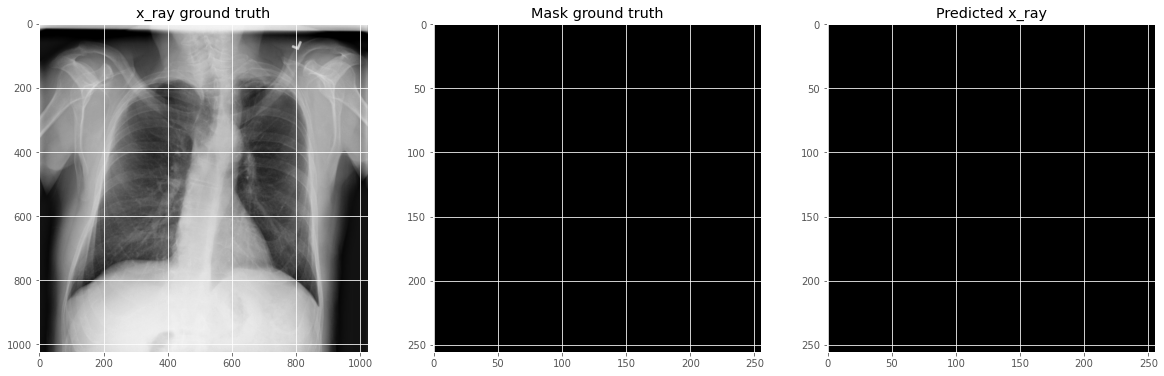

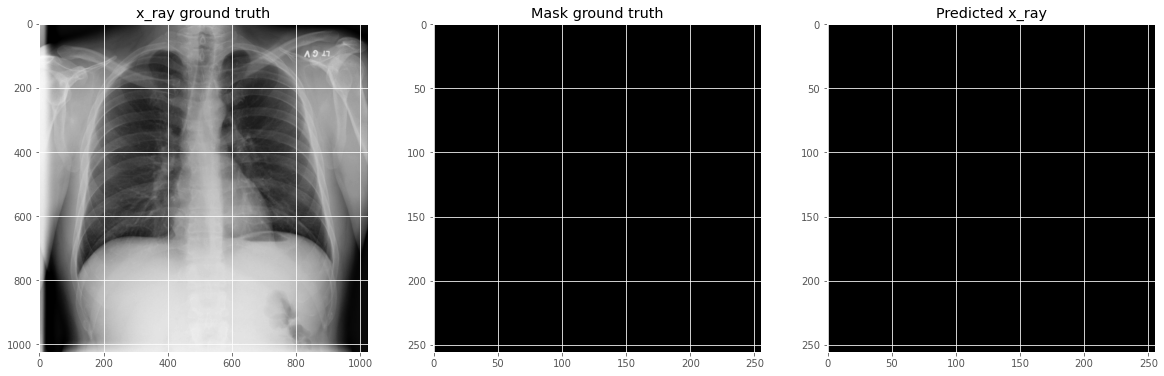

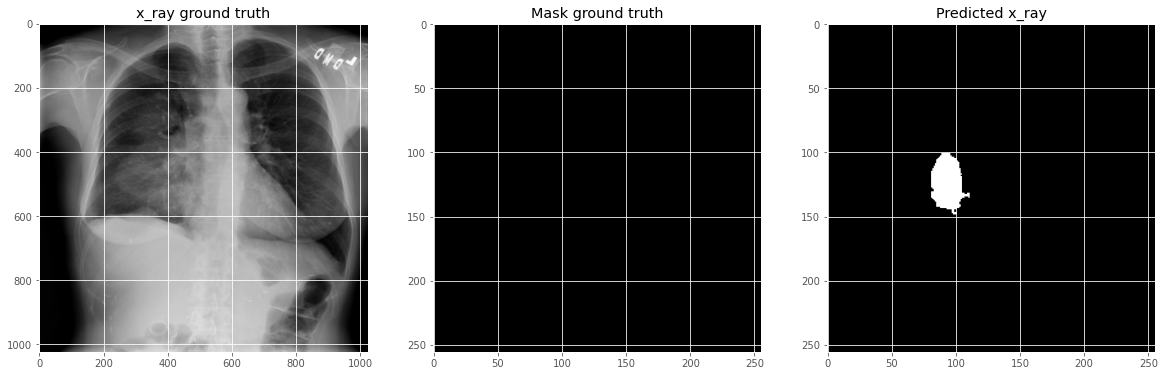

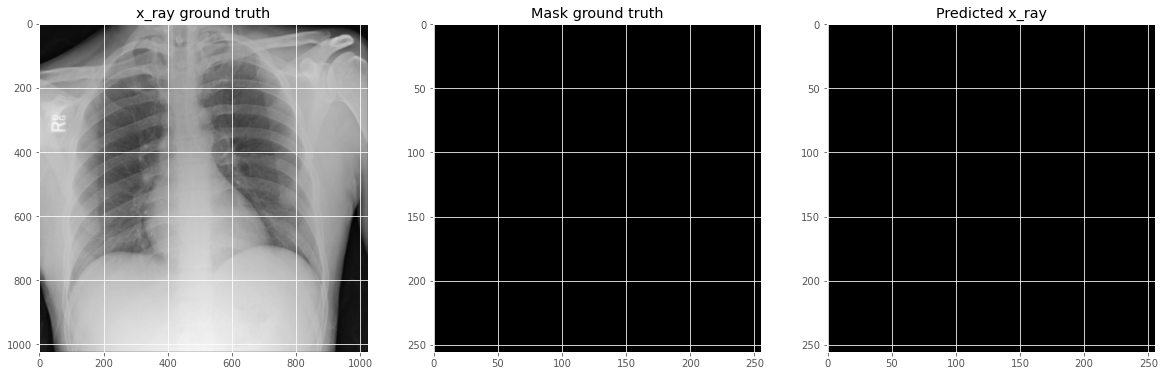

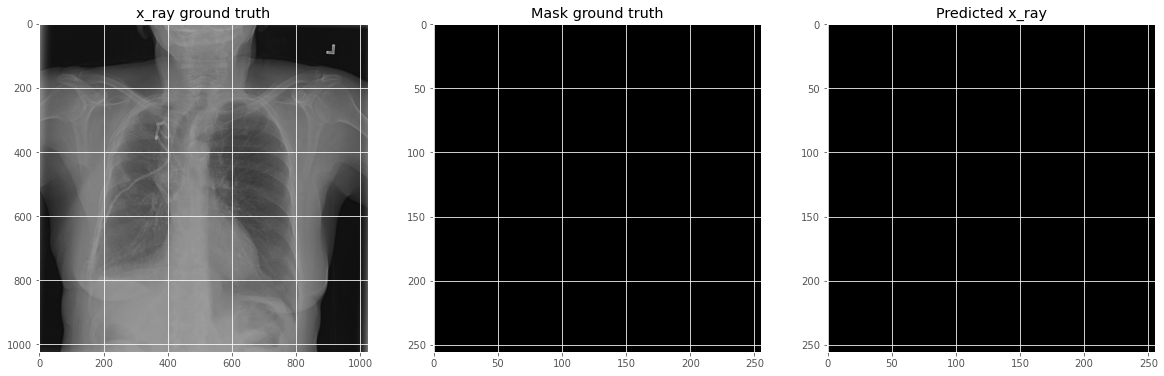

In [ ]:
for i in range(10):plot_sample1()